In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as Dt
import math

In [4]:
#define necessary variables

T = 10
nb_step = 100
dt = T/nb_step
obs_interval = 10
nb_sim = 50000

r = 0.01
v = 0.3
S0 = 100

#phoenix specific

coupon = 5
coupon_barrier_level = 80
barriere_autocall = 100
strike_PDI = 100
barriere_PDI = 70
issue_price = 100

#express in %

coupon_barrier_level = (coupon_barrier_level/100)*S0
strike_PDI = (strike_PDI/100)*S0
barriere_PDI = (barriere_PDI/100)*S0

In [6]:
# Generate Paths with BS Model

def get_paths_n_discount_factor(nb_sim, nb_step, obs_interval, r, v, T, S0):

#we decompose the BS Model to make computations faster 
    
    # we first create a matrix of Brownian Motion
    
    matrix_brownian = np.sqrt(dt)*np.random.normal(0,1,(nb_sim, nb_step))
    matrix_brownian = np.cumsum(matrix_brownian, axis = 1)

    
    
    # second matrix with the time steps t
    
    time = np.linspace(dt,T,nb_step)
    matrix_time = np.tile(time, nb_sim).reshape(nb_sim, nb_step)

    
    # we have the following in the exp part of the PDE
    
    matrix_in_exp = v*matrix_brownian + (r - (v**2)/2)*matrix_time

    
    # we have the following path for the stock
    
    matrix_stock_price = S0*np.exp(matrix_in_exp)

    
    # we add this result in a larger matrix to add S0
    
    matrix_sim = S0*np.ones((nb_sim, nb_step + 1))
    matrix_sim[:,1:] = matrix_stock_price

    
    # dataframe format
    
    Obs_list = ["Obs" if i%obs_interval == 0 else "Non_obs" for i in range(nb_step+1)]
    Stock_index_list = ["S_" + str(i) for i in range(nb_step+1)]
    Multi_cols = [Obs_list, Stock_index_list]
    df = pd.DataFrame(data = matrix_sim,
                  columns = Multi_cols,
                  index = ["Path_" + str(i) for i in range(1,nb_sim+1)])

    
    # the last line represents the discount factor based on r
    
    compound_factor = np.exp(-r*np.linspace(0,T,nb_step+1))
    df.loc["compound_factor"] = compound_factor

    obs_df = df.loc[:,"Obs"]

    return obs_df.iloc[:-1,:],obs_df.iloc[-1:,:]


    # we have the following results
    

paths_df , compound = get_paths_n_discount_factor(nb_sim = nb_sim, nb_step = nb_step, 
                                                      obs_interval = obs_interval, r = r, 
                                                      v = v, T = T, S0 = S0)

# we have the following results

# 1) the matrix of Stock Price Simulations

paths_df

,S_0,S_10,S_20,S_30,S_40,S_50,S_60,S_70,S_80,S_90,S_100
Path_1,100.0,90.447440,86.112376,62.188972,54.243562,47.831515,89.224761,91.917210,219.608056,325.997362,251.039216
Path_2,100.0,77.517516,72.871410,79.066680,55.683682,38.285550,49.988423,45.809977,48.186203,44.714367,39.813365
Path_3,100.0,102.098456,89.120787,113.794085,114.542589,123.135417,106.522806,123.553902,90.415139,72.136209,96.547800
Path_4,100.0,77.208133,70.775480,38.946053,44.661793,37.342898,26.770564,24.025549,17.509022,8.967263,10.823792
Path_5,100.0,72.432251,58.316050,82.010885,70.645374,57.656879,42.798405,79.782926,66.466389,62.262368,38.354947
...,...,...,...,...,...,...,...,...,...,...,...
Path_49996,100.0,88.781484,175.259113,211.287610,236.504726,226.950528,258.163166,174.649240,159.930633,80.775339,88.321790
Path_49997,100.0,80.091645,125.042763,91.085655,103.330669,80.635006,58.864599,59.500943,67.713140,40.588556,48.836569
Path_49998,100.0,133.285162,186.225686,198.956313,216.188135,89.679005,62.517982,33.887242,41.210755,38.055903,40.127366
Path_49999,100.0,99.558702,62.765878,29.987436,43.546255,30.915727,32.330299,22.905149,18.341051,16.596982,15.741707


In [7]:
# 2) the matrix of discount factor, used later on

compound

,S_0,S_10,S_20,S_30,S_40,S_50,S_60,S_70,S_80,S_90,S_100
compound_factor,1.0,0.99005,0.980199,0.970446,0.960789,0.951229,0.941765,0.932394,0.923116,0.913931,0.904837


(90.0, 115.0)

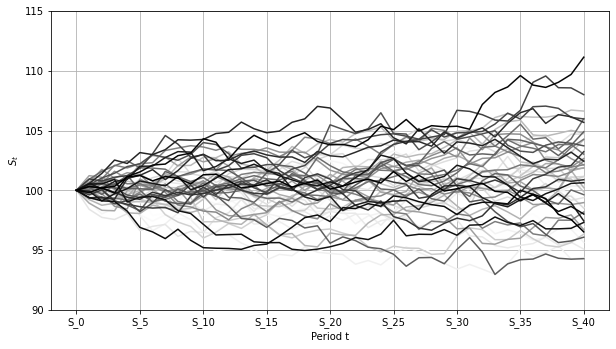

In [9]:
# plot GBM sim

paths , compounds = get_paths_n_discount_factor(nb_sim = 50, nb_step = 40, 
                                                      obs_interval = 1, r = 0.001, 
                                                      v = 0.02, T = T, S0 = 100)


paths.T.plot(legend = False, figsize= (10, 5.5), colormap = 'Greys')
plt.grid(True)
plt.ylabel('$S_{t}$')
plt.xlabel('Period t')
plt.ylim(top = 115)
plt.ylim(bottom = 90)

In [11]:
# Reliability of Monte Carlo with BS Call

from scipy.integrate import quad

# Model and Option Parameters
K = 110 # strike price
T = 10 # time-to-maturity
t = 2
St = 100
r = 0.025 # constant, risk-less short rate
sigma = 0.5 # constant volatility
nb_sim_spot = 100


def MC_Call_Value(nb_sim_spot, St = St, K = K, t = t, T = T, r = r, sigma = sigma):
    
    # we create the terminal values for ST

    vector_Brownian_Motion = np.random.normal(0,1, nb_sim_spot) * np.sqrt(T-t)

    #create vector BM
    inside_exp = (r - (sigma **2) / 2) * (T-t) + (sigma * vector_Brownian_Motion)

    spot_T = St * np.exp(inside_exp) 
    arr_payoff = np.max(spot_T-K,0)

    return np.mean(np.maximum(spot_T-K,0))/np.exp(r * (T-t))

def BSM_call_value(St = St, K = K, t = t, T = T, r = r, sigma = sigma):
    d1 = d1f(St, K, t, T, r, sigma)
    d2 = d1 - sigma * math.sqrt(T - t)
    call_value = St * N(d1) - math.exp(-r * (T - t)) * K * N(d2)
    return call_value


# Sample Data Generation
S = np.linspace(4000, 12000, 150) # vector of index level values
h = np.maximum(S - K, 0) # inner value of option


def dN(x):
    return math.exp(-0.5 * x ** 2) / math.sqrt(2 * math.pi)

def N(d): 
    return quad(lambda x: dN(x), -20, d, limit=50)[0]

def d1f(St, K, t, T, r, sigma):
    
    d1 = (math.log(St / K) + (r + 0.5 * sigma ** 2)
    * (T - t)) / (sigma * math.sqrt(T - t))
    return d1

real_call_price = BSM_call_value()

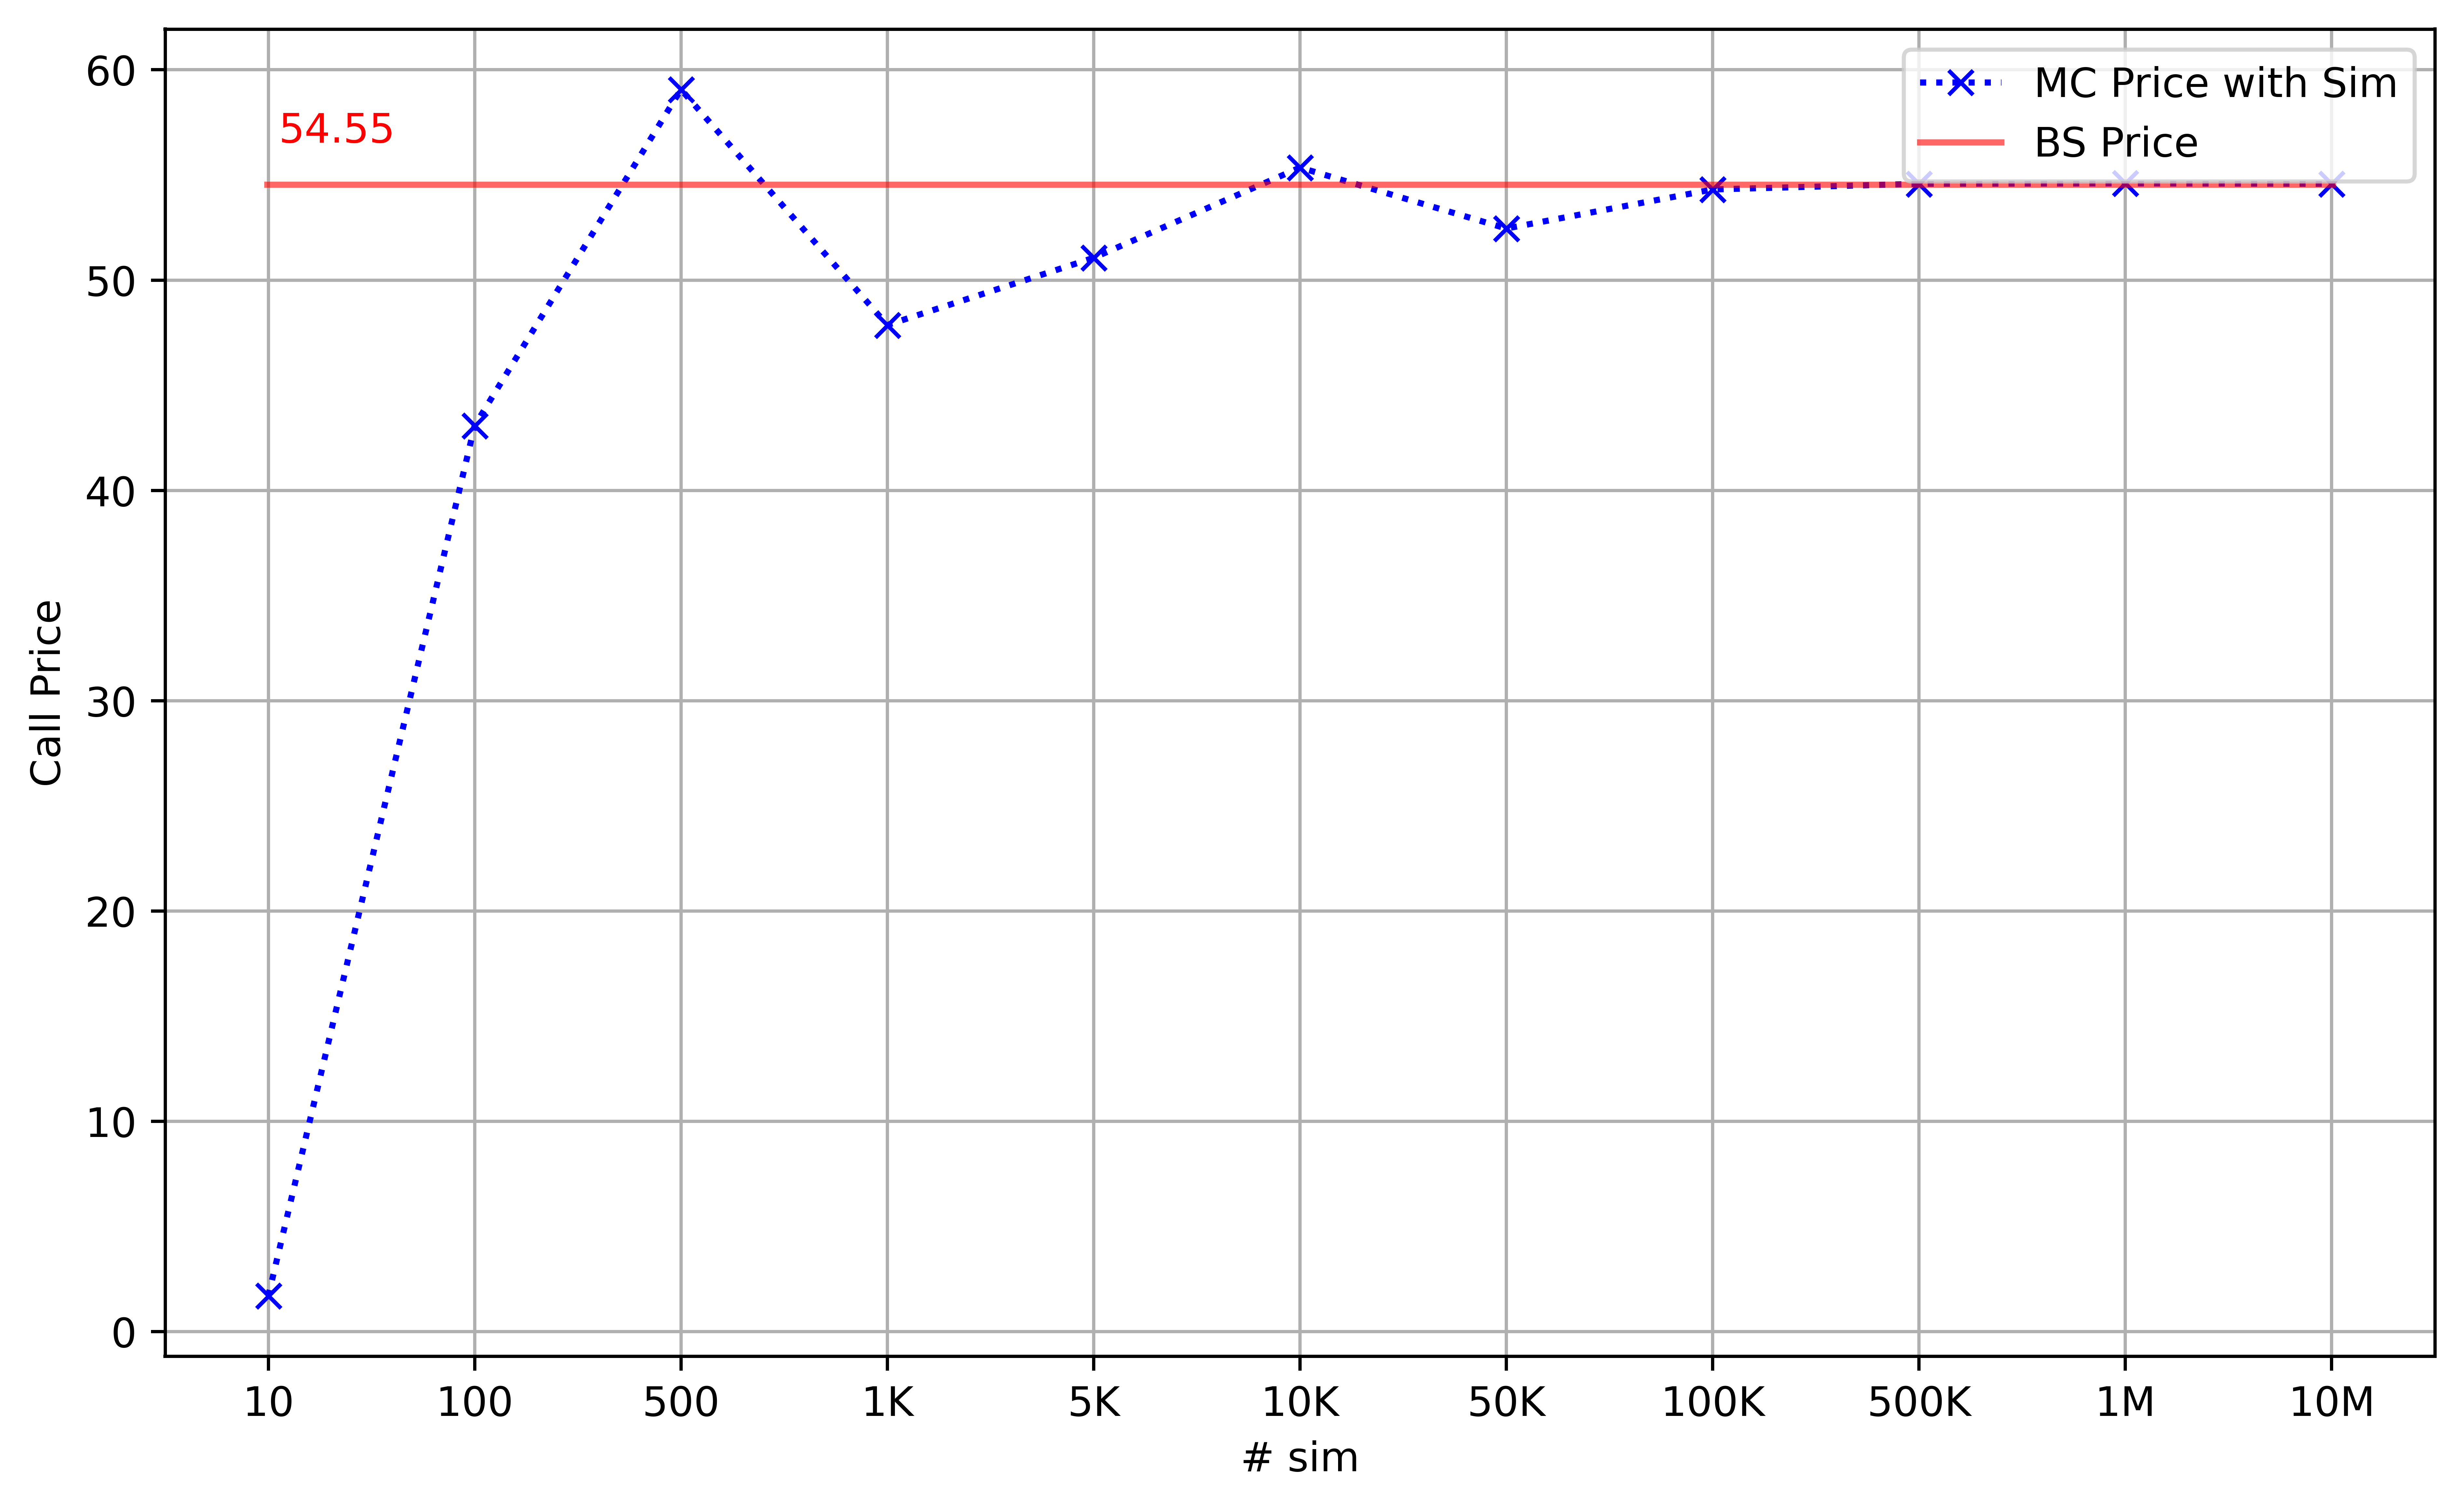

In [12]:
# range of sim

nb_sim_for_plot = [10, 100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000, 10000000]

mc_call_price_various_nb_sim = [MC_Call_Value(nb_sim_spot = nb_sim_for_plot[i]) for i in range(len(nb_sim_for_plot))]


#graph

nb_sim_for_plot_str = ['10', '100', '500', '1K', '5K', '10K', '50K', '100K', '500K', '1M', '10M']

plt.figure(figsize=(10,6), dpi= 900)
plt.plot(nb_sim_for_plot_str, mc_call_price_various_nb_sim, marker = 'x', color = 'blue', 
         linestyle = ':', label = 'MC Price with Sim')
plt.axhline(y = real_call_price, color = 'r', linestyle = '-', alpha = 0.6, label = 'BS Price', 
            xmin = 0.045, xmax = 0.955)

plt.text(x = 0.05, y = real_call_price + 2, s = str(round(real_call_price, 2)), color = 'r')
plt.grid(True)
plt.legend()
plt.xlabel('# sim')
plt.ylabel('Call Price')
plt.show()

In [20]:
def price_phoenix(T, nb_sim , nb_step, obs_interval, r, v, S0, coupon,
                  coupon_barrier_level, barriere_autocall, strike_PDI, 
                  barriere_PDI, issue_price):

    #we use the function above to generate stock prices + discount factor   
    paths_df , compound = get_paths_n_discount_factor(nb_sim = nb_sim, nb_step = nb_step, 
                                                      obs_interval = obs_interval, r = r, 
                                                      v = v, T = T, S0 = S0)
    
    
# We decompose the Phoenix Payoff in two parts: before matu and at matu

#1) we compute the value of the Bond Redemption if autocalled


    # create matrix with only callable part    
    test_reduced = paths_df.iloc[:,1:-1].values
    
    
    # nb_sim = the number of simulations and nb_path = autocallable frequency   
    nb_sim, nb_path = test_reduced.shape

    
# we want to retrive the first period where Autocall = "True" 
# BUT if we have no autocall -> we want the autocall period to be 0
    
    # first we check when we have St > autocall barrier
    mat_candidats = test_reduced >= barriere_autocall

    # exclude candidates where we have false autocall --> i.e no autocall   
    col_index_argmax = mat_candidats.argmax(1)
    vals_argmax = test_reduced[list(range(nb_sim)), col_index_argmax]

    # exclude these false values
    is_correct_argmax = vals_argmax >= barriere_autocall
    one_if_right_argmax = 1*is_correct_argmax

    # display in a 0 1 matrix format where 1 = the autocall period
    zeros_mat = np.zeros(test_reduced.shape)
    zeros_mat[list(range(nb_sim)), col_index_argmax] = one_if_right_argmax 

    # we multiply by the issue_price of the bond
    final = issue_price *zeros_mat


#we now need to price the value of the coupons 

    # create a true false matrix if stock value > coupon barrier and multiply by the value of the stock at that moment
    mat_coupon = test_reduced*(test_reduced >= coupon_barrier_level)

    #we check the first value issued where boolean cdt is > autocall level
    # we however may have value that do not trigger autocall
    for row_argmax, col_argmax in zip(list(range(nb_sim)),col_index_argmax):
       
        #we check if values until autocall are greater than coupon barrier
        if test_reduced[row_argmax, col_argmax] >= coupon_barrier_level:
            
            #if value is > coupon barrier then all values after are set to 0 
            mat_coupon[row_argmax, col_argmax + 1:] = 0
            
        #we have the folowing coupon CF matrix
    mat_coupon = coupon *(mat_coupon > 0)

#2) We now look at what happens at maturity

    #values at matu in a df format
    Scenari = pd.DataFrame()
    Scenari['last_period_stock_val'] = paths_df.iloc[:,-1:].values.flatten()
    
    #we add a column for CF values
    Scenari['CF'] = ""

    #we check line by line at the three possible scenarios
        #1) ST > coupon barrier -> PDI not activated and Bond redeemed and Coupon earned
        #2) coupon barrier > ST > PDI barrier -> PDI not activated and bond redeemed
        #3) PDI barrier > ST -> PDI activated
    
    for i in range(len(Scenari)):
        if Scenari['last_period_stock_val'][i] < barriere_PDI:
            Scenari['CF'][i] = Scenari['last_period_stock_val'][i] 

        elif (Scenari['last_period_stock_val'][i] > barriere_PDI) & (Scenari['last_period_stock_val'][i] < coupon_barrier_level):
            Scenari['CF'][i] = issue_price 

        else: 
            Scenari['CF'][i] = issue_price + coupon
            
    Scenari['CF'] = np.where((1 - np.sum(final > 0, axis = 1))==1,Scenari['CF'],0)
    
    

    #we compute the proba of autocall and proba of getting to matu
     
    list_prob_autocall_before_mat = list(np.mean(final > 0, axis = 0))
    list_prob_autocall =  list_prob_autocall_before_mat + [0]
    arr_prob_autocall = np.array(list_prob_autocall)
    
    
    #we compute the proba of earning coupon at matu
    prob_coupon_before_mat = np.mean(mat_coupon > 0, axis=0)
    arr_prob_coupon = np.array(list(prob_coupon_before_mat) + [0])
    
    #prob that EKIP is activated within the not autocalled path
    
    EKIP_CF = Scenari['CF'].values
    EKIP_CF = np.sum(EKIP_CF) / np.sum(EKIP_CF > 0)
    arr_cf_EKIP = np.array([0]*(nb_path) + [EKIP_CF])
    
    expected_autocall = arr_prob_autocall * issue_price
    expected_coupon = arr_prob_coupon*coupon
    expected_EKIP = arr_cf_EKIP * (1 - sum(arr_prob_autocall))

    arr_compound = compound.values.flatten()[1:]
    
    price = (expected_autocall + expected_coupon + expected_EKIP) * arr_compound
                                   
    return sum(price), arr_prob_autocall

In [21]:
#the price of the Phoenix Autocall for above params

price, arr_prob_autocall = price_phoenix(S0 = S0, T = T, nb_sim = nb_sim , nb_step = nb_step, obs_interval = obs_interval, r = r,
              v = v, coupon = coupon, coupon_barrier_level = coupon_barrier_level, 
              barriere_autocall = barriere_autocall, strike_PDI = strike_PDI, 
              barriere_PDI = barriere_PDI, issue_price = issue_price)


print('The Price of the Phoenix Autocall is ' + str(round(price,2))+ '.')

The Price of the Phoenix Autocall is 87.56.
